## Week 5 Notebook

Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, Semester Two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data using the methods you have learned about in this course and in this program and draw interesting conclusions. 

For Week 5, include concepts such as support vector machines, the kernel trick, and regularization for support vector machines. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.svm import SVC, LinearSVC

# data preprocesing and scoring
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report

random_state = 0

In [2]:
# encode categorical features
def encode_categories(df: pd.DataFrame):
    df_encoded = df.copy()
    mappings = {}
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    
    for col in cat_cols:
        # get the unique categories (in order of appearance)
        uniques = df_encoded[col].dropna().unique().tolist()
        # build a mapping: category -> code
        mapping = {cat: code for code, cat in enumerate(uniques)}
        mappings[col] = mapping

        # map (leave NaN as NaN)
        df_encoded[col] = df_encoded[col].map(mapping).astype("int64")

    return df_encoded, mappings

In [3]:
# Create a function to load and split data
def load_and_split_data(file_path, test_size=0.2, random_state=random_state, choice='norm'):

    # Read and Encode catigorical features
    df, _ = encode_categories(pd.read_csv(file_path))

    # Feature and target
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # reshaye y to 1D array
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    if choice == 'reg':
        # Regularize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    else:
        # Bormalize the features
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert scaled features back to DataFrames
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, df

### Model Funcitons

In [ ]:
# Create a function that runs SVC or SVR with dynamic class weight option
def svc_model(X_train, y_train, X_test, y_test, class_weight='balanced', **model_params):

    model = SVC(**model_params, class_weight=class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred

In [19]:
# Create function to run LinearSVC
def linear_svc_model(X_train, y_train, X_test, y_test, class_weight='balanced', **model_params):
    
    model = LinearSVC(**model_params, class_weight=class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, y_pred

In [ ]:
def gridsearchcv(model, X_train, y_train, param_dict=None, random_state=random_state):

    # Define the model
    gb_model = model(random_state=random_state)

    # Define the parameter grid
    param_dist = param_dict

    # Use GridSearchCV to find the best parameters
    search = GridSearchCV(
        estimator=gb_model,
        param_grid=param_dist,
        scoring='accuracy',
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state),  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
        n_jobs=-1,  # Use all available cores
        return_train_score=True
    )

    # Fit the GridSearchCV
    search.fit(X_train, y_train)  

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Select relevant columns for readability
    results = results[[
        # 'param_kernel',
        'param_C',
        # 'param_gamma',
        'mean_test_score',
        'std_test_score',
        'mean_train_score',  # Include training score
        'std_train_score',   # Include standard deviation of training score
        'rank_test_score'
    ]]

    # Sort by rank (best scores first)
    results = results.sort_values(by='rank_test_score')

    # Rename columns for printing only
    renamed_results = results.rename(
        columns={
            # 'param_kernel': 'kernel',
            'param_C': 'C',
            # 'param_gamma': 'gamma',
            'mean_test_score': 'mean_cv_score',
            'std_test_score': 'std_cv_score',
            'mean_train_score': 'mean_train_score',
            'std_train_score': 'std_train_score'
        }
    ).drop(columns=['rank_test_score'])

    # Print the results as a table
    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_acc = search.best_score_
    print(f"Best CV Score: {grid_cv_acc:.4f}")

    return grid_best_params, grid_cv_acc

In [24]:
def evaluate_results(y_test, y_pred, model):
    
    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    print("Classification Report:")
    print(report)
    print("\n")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Calculate f1 score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 score: {f1:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [8]:
# Load the data
# Regularized Data
X_train_car_reg, X_test_car_reg, y_train_car_reg, y_test_car_reg, df_car_reg = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\carclaims_cleaned.csv', choice='reg')
X_train_ins_reg, X_test_ins_reg, y_train_ins_reg, y_test_ins_reg, df_ins_reg = load_and_split_data(r'C:\Users\JT von Seggern\DS Masters Repos\2025-spring-B2\data\insurance_claims_cleaned.csv', choice='reg')

In [13]:
SVC_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.01, .1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

In [14]:
# Run grid search on the insurance dataset
ins_reg_params, ins_reg_acc = gridsearchcv(SVC, X_train_ins_reg, y_train_ins_reg, param_dict=SVC_params,random_state=random_state)


Search Results (Top 5):

 kernel     C gamma  mean_cv_score  std_cv_score  mean_train_score  std_train_score
sigmoid  10.0  auto        0.78225      0.027081          0.616125         0.012459
 linear   1.0 scale        0.78200      0.024832          0.818187         0.010651
 linear   1.0  auto        0.78200      0.024832          0.818187         0.010651
 linear 100.0 scale        0.78200      0.024451          0.818313         0.010956
 linear 100.0  auto        0.78200      0.024451          0.818313         0.010956

Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
Best CV RMSE: 0.7823


In [11]:
lin_SVC_params = {
    'C': [.01, .1, 1, 10, 100]
}

In [16]:
# Run grid search for the car claims dataset
car_reg_params, car_reg_acc = gridsearchcv(LinearSVC, X_train_car_reg, y_train_car_reg, param_dict=lin_SVC_params)


Search Results (Top 5):

     C  mean_cv_score  std_cv_score  mean_train_score  std_train_score
  0.01       0.939916      0.000164          0.939932         0.000038
  0.10       0.939916      0.000164          0.939932         0.000038
  1.00       0.939916      0.000164          0.939932         0.000038
 10.00       0.939916      0.000164          0.939932         0.000038
100.00       0.939916      0.000164          0.939932         0.000038

Best Parameters: {'C': 0.01}
Best CV RMSE: 0.9399


In [20]:
# Run SVC for car claims and insurance claims
model_car_reg, y_pred_car_reg = linear_svc_model(X_train_car_reg, y_train_car_reg, X_test_car_reg, y_test_car_reg, **car_reg_params)
model_ins_reg, y_pred_ins_reg = svc_model(X_train_ins_reg, y_train_ins_reg, X_test_ins_reg, y_test_ins_reg, **ins_reg_params)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      2902
           1       0.13      0.88      0.22       182

    accuracy                           0.63      3084
   macro avg       0.56      0.75      0.49      3084
weighted avg       0.94      0.63      0.73      3084



Accuracy: 0.63
F1 score: 0.22


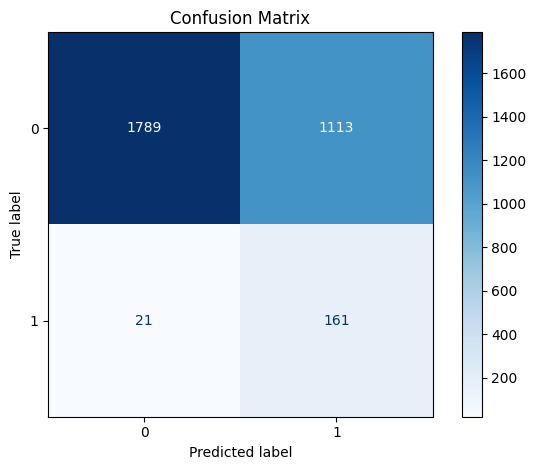

In [25]:
# Evaluate the car claims dataset
evaluate_results(y_test_car_reg, y_pred_car_reg, model_car_reg)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       143
           1       0.51      0.86      0.64        57

    accuracy                           0.72       200
   macro avg       0.71      0.76      0.70       200
weighted avg       0.80      0.72      0.73       200



Accuracy: 0.72
F1 score: 0.64


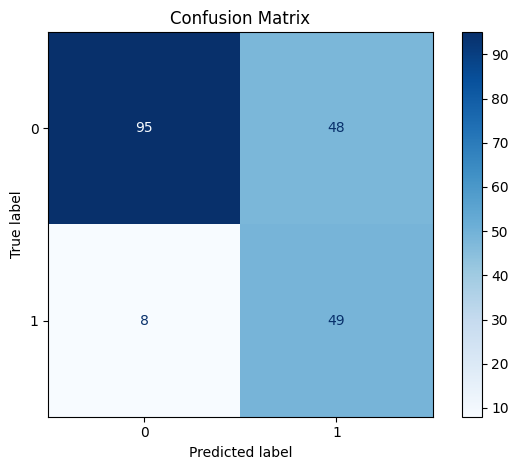

In [26]:
# Evaluate the insurance claims dataset
evaluate_results(y_test_ins_reg, y_pred_ins_reg, model_ins_reg)